In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from metrics import MCC_binary, MCC_multi

import Models

Using TensorFlow backend.


In [2]:
# Enable FP16

# https://medium.com/@noel_kennedy/how-to-use-half-precision-float16-when-training-on-rtx-cards-with-tensorflow-keras-d4033d59f9e4

import tensorflow.keras.backend as K

K.set_floatx('float16')

# default is 1e-7 which is too small for float16.  
# Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
K.set_epsilon(1e-4)

In [3]:
# DATA PATHS

TRAIN_FOLDER_PATH = './data/train/'
VAL_FOLDER_PATH = './data/validation/'
TEST_FOLDER_PATH = './data/test/'

MODEL_NAME = 'mycats-classification'

In [4]:
# Hyper parameters

learning_rate = 2e-5
batch_size = 20
num_epochs = 200
classes = 2
loss = "categorical_crossentropy"

In [5]:
# Image properties

img_width = 299
img_height = 299
img_depth = 3

In [6]:
# Data generator

data_gen = ImageDataGenerator(
    rescale = 1 / 255.0,
    rotation_range=30,
    zoom_range=[0.5, 1.0],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip = True,
    fill_mode = "nearest"
)

def get_train_generator(img_height, img_width):
    train_generator = data_gen.flow_from_directory(
        TRAIN_FOLDER_PATH,
        target_size = (img_height, img_width),
        color_mode = 'rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True
    )
    
    return train_generator

def get_validation_generator(img_height, img_width):
    validation_generator = data_gen.flow_from_directory(
        VAL_FOLDER_PATH,
        target_size = (img_height, img_width),
        color_mode = 'rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True
    )
    
    return validation_generator

def get_test_generator(img_height, img_width):
    test_generator = data_gen.flow_from_directory(
        TEST_FOLDER_PATH,
        target_size = (img_height, img_width),
        color_mode='rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False
    )
    
    return test_generator

In [7]:
# Callbacks
def get_callbacks():
    chk_name = 'chk_' + MODEL_NAME + '.h5'
    mc = ModelCheckpoint(chk_name, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    return [mc]


In [8]:
# Compile the model

def compile_model(model):
    opt = SGD(lr = learning_rate)
    
    model.compile(loss = loss, optimizer = opt, metrics=["accuracy"])
    
    return model

In [9]:
# Fit the model

def fit_model(model, train_generator, validation_generator):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.n // train_generator.batch_size,
        epochs = num_epochs,
        validation_data = validation_generator,
        validation_steps = validation_generator.n // validation_generator.batch_size,
        use_multiprocessing = False,
        callbacks = get_callbacks())
    
    return history, model


In [10]:
# Save model
def save_model(model, model_name):
    model.save(model_name + '.h5')

In [11]:
# Evaluate the model

def evaluate_model(model, validation_generator):
    return model.evaluate_generator(validation_generator, steps = validation_generator.n // validation_generator.batch_size)


In [12]:
# Predictions

def get_predictions(model, test_generator):
    test_generator.reset()
    
    predIdx = model.predict_generator(test_generator, steps = (test_generator.n // test_generator.batch_size) + 1)
    
    predIdx = np.argmax(predIdx, axis=1)
    
    return predIdx

In [13]:
# Plot accuracy and loss

def plot_metrics(history):
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')

    # summarize history for loss
    plt.subplot(2,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    
    # Plot MCC_binary values
    #plt.subplot(2,2,3)
    #plt.plot(history.history['MCC_binary'])
    #plt.plot(history.history['val_MCC_binary'])
    #plt.title('model MCC_binary')
    #plt.ylabel('MCC_binary')
    #plt.xlabel('epoch')
    #plt.legend(['train', 'validation'], loc='lower right')
    
    plt.show()

In [14]:
# Show evaluation metrics

def show_eval_metrics(model, metrics):
    for idx, m in enumerate(model.metrics_names):
        print("{}: {:.4f}".format(m, metrics[idx]))


In [15]:
# Show test metrics

def show_test_metrics(predictions, test_generator):
    print("## Classification report ##")
    print(classification_report(test_generator.classes, predictions, target_names=test_generator.class_indices.keys()))

    cm = confusion_matrix(test_generator.classes, predictions)
    
    total = sum(sum(cm))
    acc = (cm[0,0] + cm[1,1]) / total
    sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
    specificity = cm[1,1] / (cm[1,0] + cm[1,1])

    print("## Other values ##")
    print("acc: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))
    print("MCC multi: {:.4f}".format(MCC_multi(cm)))
    

In [16]:
# Plot confusion matrix

def plot_confusion_matrix(predictions, test_generator, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(test_generator.classes, predictions)
    classes = test_generator.class_indices.keys()
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [17]:
# Create the generators

train_generator = get_train_generator(img_height, img_width)
validation_generator = get_validation_generator(img_height, img_width)
test_generator = get_test_generator(img_height, img_width)

Found 98 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


In [18]:
# Xception model

model = Models.build_xception(img_height, img_width, img_depth)

In [19]:
# EfficientNet model

#img_width = 224
#img_height = 224
#model = Models.build_efficientnet(img_height, img_width, img_depth)
#model.summary()

In [20]:
# Show architecture

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               104858112 
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1

In [21]:
# Compile

model = compile_model(model)

In [22]:
# Train

history, model = fit_model(model, train_generator, validation_generator)

Epoch 1/200


W0827 02:45:56.615637 139908563633984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


3/4 [=====================>........] - ETA: 2s - loss: 1.0176 - accuracy: 0.5518
Epoch 00001: val_accuracy improved from -inf to 0.54980, saving model to chk_mycats-classification.h5
4/4 [==============================] - 9s 2s/step - loss: 1.0582 - accuracy: 0.5127 - val_loss: 0.7024 - val_accuracy: 0.5498
Epoch 2/200
3/4 [=====================>........] - ETA: 0s - loss: 1.1932 - accuracy: 0.6001
Epoch 00002: val_accuracy improved from 0.54980 to 0.62500, saving model to chk_mycats-classification.h5
4/4 [==============================] - 4s 927ms/step - loss: 1.1673 - accuracy: 0.6025 - val_loss: 0.6770 - val_accuracy: 0.6250
Epoch 3/200
3/4 [=====================>........] - ETA: 0s - loss: 1.2568 - accuracy: 0.5669
Epoch 00003: val_accuracy did not improve from 0.62500
4/4 [==============================] - 2s 577ms/step - loss: 1.2681 - accuracy: 0.5513 - val_loss: 0.6748 - val_accuracy: 0.6001
Epoch 4/200
3/4 [=====================>........] - ETA: 0s - loss: 0.9565 - accuracy: 0

Epoch 29/200
3/4 [=====================>........] - ETA: 0s - loss: 0.9141 - accuracy: 0.6167
Epoch 00029: val_accuracy did not improve from 0.97510
4/4 [==============================] - 2s 527ms/step - loss: 0.8311 - accuracy: 0.6626 - val_loss: 0.3749 - val_accuracy: 0.8750
Epoch 30/200
3/4 [=====================>........] - ETA: 0s - loss: 0.7376 - accuracy: 0.7241
Epoch 00030: val_accuracy did not improve from 0.97510
4/4 [==============================] - 2s 544ms/step - loss: 0.7607 - accuracy: 0.6797 - val_loss: 0.3668 - val_accuracy: 0.9502
Epoch 31/200
3/4 [=====================>........] - ETA: 0s - loss: 0.5927 - accuracy: 0.6895
Epoch 00031: val_accuracy did not improve from 0.97510
4/4 [==============================] - 2s 532ms/step - loss: 0.4850 - accuracy: 0.7437 - val_loss: 0.3840 - val_accuracy: 0.9248
Epoch 32/200
3/4 [=====================>........] - ETA: 0s - loss: 0.8082 - accuracy: 0.7168
Epoch 00032: val_accuracy did not improve from 0.97510
4/4 [============

3/4 [=====================>........] - ETA: 0s - loss: 0.5706 - accuracy: 0.6724
Epoch 00058: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 578ms/step - loss: 0.5514 - accuracy: 0.7051 - val_loss: 0.2988 - val_accuracy: 0.8999
Epoch 59/200
3/4 [=====================>........] - ETA: 0s - loss: 0.6803 - accuracy: 0.6724
Epoch 00059: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 573ms/step - loss: 0.6140 - accuracy: 0.7051 - val_loss: 0.3207 - val_accuracy: 0.9248
Epoch 60/200
3/4 [=====================>........] - ETA: 0s - loss: 0.3826 - accuracy: 0.8447
Epoch 00060: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 530ms/step - loss: 0.4028 - accuracy: 0.8462 - val_loss: 0.2319 - val_accuracy: 0.9248
Epoch 61/200
3/4 [=====================>........] - ETA: 0s - loss: 0.4580 - accuracy: 0.7998
Epoch 00061: val_accuracy did not improve from 1.00000
4/4 [=========================

Epoch 88/200
3/4 [=====================>........] - ETA: 0s - loss: 0.4095 - accuracy: 0.8667
Epoch 00088: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 588ms/step - loss: 0.4681 - accuracy: 0.8203 - val_loss: 0.1907 - val_accuracy: 0.9248
Epoch 89/200
3/4 [=====================>........] - ETA: 0s - loss: 0.6476 - accuracy: 0.7168
Epoch 00089: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 590ms/step - loss: 0.5671 - accuracy: 0.7500 - val_loss: 0.2175 - val_accuracy: 0.9502
Epoch 90/200
3/4 [=====================>........] - ETA: 0s - loss: 0.4913 - accuracy: 0.7930
Epoch 00090: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 556ms/step - loss: 0.4189 - accuracy: 0.8203 - val_loss: 0.2297 - val_accuracy: 0.9502
Epoch 91/200
3/4 [=====================>........] - ETA: 0s - loss: 0.4006 - accuracy: 0.7930
Epoch 00091: val_accuracy did not improve from 1.00000
4/4 [============

Epoch 118/200
3/4 [=====================>........] - ETA: 0s - loss: 0.4977 - accuracy: 0.8335
Epoch 00118: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 618ms/step - loss: 0.4983 - accuracy: 0.8203 - val_loss: 0.2500 - val_accuracy: 0.8750
Epoch 119/200
3/4 [=====================>........] - ETA: 0s - loss: 0.3586 - accuracy: 0.8501
Epoch 00119: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 572ms/step - loss: 0.3327 - accuracy: 0.8501 - val_loss: 0.1345 - val_accuracy: 0.9751
Epoch 120/200
3/4 [=====================>........] - ETA: 0s - loss: 0.4026 - accuracy: 0.8169
Epoch 00120: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 548ms/step - loss: 0.3446 - accuracy: 0.8335 - val_loss: 0.2300 - val_accuracy: 0.8999
Epoch 121/200
3/4 [=====================>........] - ETA: 0s - loss: 0.2081 - accuracy: 0.9312
Epoch 00121: val_accuracy did not improve from 1.00000
4/4 [========

Epoch 148/200
3/4 [=====================>........] - ETA: 0s - loss: 0.3564 - accuracy: 0.8169
Epoch 00148: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 593ms/step - loss: 0.3422 - accuracy: 0.8252 - val_loss: 0.1291 - val_accuracy: 0.9751
Epoch 149/200
3/4 [=====================>........] - ETA: 0s - loss: 0.2839 - accuracy: 0.8794
Epoch 00149: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 550ms/step - loss: 0.3554 - accuracy: 0.8335 - val_loss: 0.1020 - val_accuracy: 1.0000
Epoch 150/200
3/4 [=====================>........] - ETA: 0s - loss: 0.2987 - accuracy: 0.8447
Epoch 00150: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 533ms/step - loss: 0.3443 - accuracy: 0.8076 - val_loss: 0.1465 - val_accuracy: 0.9248
Epoch 151/200
3/4 [=====================>........] - ETA: 0s - loss: 0.4141 - accuracy: 0.8105
Epoch 00151: val_accuracy did not improve from 1.00000
4/4 [========

Epoch 178/200
3/4 [=====================>........] - ETA: 0s - loss: 0.3109 - accuracy: 0.8667
Epoch 00178: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 599ms/step - loss: 0.3047 - accuracy: 0.8877 - val_loss: 0.1110 - val_accuracy: 0.9502
Epoch 179/200
3/4 [=====================>........] - ETA: 0s - loss: 0.3068 - accuracy: 0.8623
Epoch 00179: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 557ms/step - loss: 0.2614 - accuracy: 0.8848 - val_loss: 0.1742 - val_accuracy: 0.9502
Epoch 180/200
3/4 [=====================>........] - ETA: 0s - loss: 0.2294 - accuracy: 0.8965
Epoch 00180: val_accuracy did not improve from 1.00000
4/4 [==============================] - 2s 525ms/step - loss: 0.3448 - accuracy: 0.8462 - val_loss: 0.1319 - val_accuracy: 0.9751
Epoch 181/200
3/4 [=====================>........] - ETA: 0s - loss: 0.1446 - accuracy: 0.9136
Epoch 00181: val_accuracy did not improve from 1.00000
4/4 [========

In [23]:
# Save model
save_model(model, MODEL_NAME)

In [24]:
# Evaluate

metrics = evaluate_model(model, validation_generator)
show_eval_metrics(model, metrics)

loss: 0.1116
accuracy: 1.0000


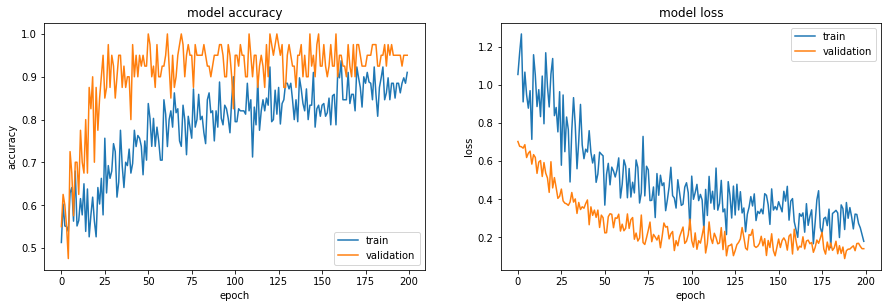

In [25]:
# Plot metrics from history

plot_metrics(history)

In [26]:
# Load model

#from tensorflow.keras.models import load_model

#model = load_model('mycats-classification.h5', custom_objects={'MCC_binary':MCC_binary})

In [27]:
# Predictions

predictions = get_predictions(model, test_generator)

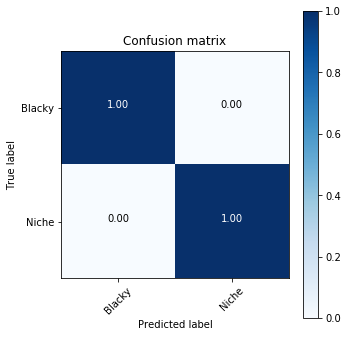

In [28]:
# Confusion matrix

plot_confusion_matrix(predictions, test_generator)

In [29]:
# Show final metrics

show_test_metrics(predictions, test_generator)

## Classification report ##
              precision    recall  f1-score   support

      Blacky       1.00      1.00      1.00         9
       Niche       1.00      1.00      1.00        16

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

## Other values ##
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000
MCC multi: 1.0000
